# Traffic Forecasting Analysis

Traffic predictions using different models.

Import required package and connect to Google Drive

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Get dataset files

In [ ]:
#METR-LA dataset without saturdays and sundays
#cp /content/drive/MyDrive/modified-METRLA.csv /content/dataset.csv

#Pems-bay dataset
#cp /content/drive/MyDrive/pems-bay.csv /content/dataset.csv

#Pemsd7-m dataset
!cp /content/drive/MyDrive/pemsd7-m.csv /content/dataset.csv

Create DataFrame and visualize its structure

In [ ]:
#dataset path
path = '/content/dataset.csv'

#for modified metr-la
#df = pd.read_csv(path, index_col=None)

#for all other dataset add columns header
df = pd.read_csv(path, header=None)

In [ ]:
#remove entries with null values
df = df.dropna(axis=0)

shape = df.shape
size = df.size

print(f'Dataframe shape: {shape}')
print(f'Number of elements: {size}')
df.head()

Dataframe shape: (12672, 228)
Number of elements: 2889216


,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,71.1,66.0,64.6,65.6,67.1,71.9,68.6,67.7,65.8,40.9,...,69.1,70.9,65.0,64.5,66.6,66.6,65.0,69.3,67.7,68.9
1,68.1,66.8,61.7,66.7,64.5,71.6,72.3,64.9,65.6,40.1,...,70.6,65.4,65.0,64.9,65.1,67.7,65.0,67.7,68.8,68.8
2,68.0,64.3,66.6,68.7,68.1,70.5,70.2,61.7,63.4,39.6,...,72.2,70.5,65.0,64.7,66.7,68.9,65.0,70.2,69.1,68.7
3,68.3,67.8,65.9,66.6,67.9,70.3,69.8,67.6,63.2,37.6,...,71.2,69.7,65.0,65.2,67.2,66.9,65.0,70.4,67.3,69.0
4,68.9,69.5,61.2,67.4,64.0,68.1,67.0,66.7,64.2,36.8,...,71.3,65.8,65.0,66.3,66.7,66.2,65.0,68.0,67.4,68.1


In [ ]:
#convert to numpy array
dataset = df.values

Visualize values from a sensor in the first day

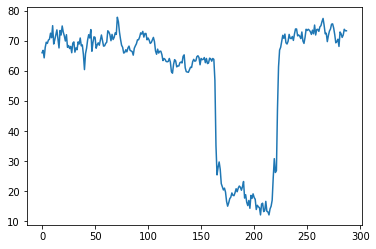

In [ ]:
#number of values in a day
day_size = 288

#select sensor
sensorID = 1

#extract values from sensor
sensor = dataset[:, sensorID]

plt.plot(np.arange(day_size), sensor[:day_size])
plt.show()

## Models

### Regression for all data

Predict all the velocity values in future days

In [ ]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(123)

In [ ]:
#osberved data point window
M = 12
#prediciton data point window
H = 3

In [ ]:
def transform_data(data, M, H):
  n_sensors = data.shape[1]
  total_len = len(data)
  window_len = total_len - M - H
  X = np.zeros([window_len, M * n_sensors])
  Y = np.zeros([window_len, n_sensors])
  for i in range(window_len):
      start = i
      end = i + M
      X[i, :] = data[start: end].reshape(M * n_sensors)
      Y[i] = data[end + H - 1]

  return np.array(X), np.array(Y)

In [ ]:
#remove date values if metr-la modified
#dataset = dataset[:,1:]

#divide in train and test
train_rate = 0.7
val_rate = 0.15
train_size = int(dataset.shape[0] * train_rate)
val_size = int(dataset.shape[0] * val_rate)

train_set, val_set, test_set = dataset[:train_size, :], dataset[train_size:train_size+val_size, :], dataset[train_size+val_size:, :]

#scale data
scaler = StandardScaler()
train_set = scaler.fit_transform(train_set)
val_set = scaler.transform(val_set)
test_set = scaler.transform(test_set)

X_train, Y_train = transform_data(train_set, M, H)
X_val, Y_val = transform_data(val_set, M, H)
X_test, Y_test = transform_data(test_set, M, H)

print(f'X train shape: {X_train.shape}')
print(f'X val shape: {X_val.shape}')
print(f'X test shape: {X_test.shape}')
print(f'Y train shape: {Y_train.shape}')
print(f'Y val shape: {Y_val.shape}')
print(f'Y test shape: {Y_test.shape}')

X train shape: (8855, 2736)
X val shape: (1885, 2736)
X test shape: (1887, 2736)
Y train shape: (8855, 228)
Y val shape: (1885, 228)
Y test shape: (1887, 228)


In [ ]:
model = keras.models.Sequential([
    tf.keras.Input(X_train.shape[1]),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(Y_train.shape[1], activation='relu')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 512)               1401344   
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 228)              

In [ ]:
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy',keras.losses.MeanSquaredError(), keras.losses.MeanAbsoluteError(), keras.losses.MeanAbsolutePercentageError()])

In [ ]:
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_val, Y_val))

Epoch 1/100
277/277 [==============================] - 4s 14ms/step - loss: 0.9561 - accuracy: 0.0045 - mean_squared_error: 0.9560 - mean_absolute_error: 0.6651 - mean_absolute_percentage_error: 134.6114 - val_loss: 1.0316 - val_accuracy: 0.0085 - val_mean_squared_error: 1.0319 - val_mean_absolute_error: 0.6403 - val_mean_absolute_percentage_error: 110.7226
Epoch 2/100
277/277 [==============================] - 4s 13ms/step - loss: 0.8835 - accuracy: 0.0075 - mean_squared_error: 0.8835 - mean_absolute_error: 0.6089 - mean_absolute_percentage_error: 116.9057 - val_loss: 1.0025 - val_accuracy: 0.0064 - val_mean_squared_error: 1.0028 - val_mean_absolute_error: 0.6033 - val_mean_absolute_percentage_error: 114.5073
Epoch 3/100
277/277 [==============================] - 4s 13ms/step - loss: 0.8595 - accuracy: 0.0105 - mean_squared_error: 0.8593 - mean_absolute_error: 0.5810 - mean_absolute_percentage_error: 114.0886 - val_loss: 0.9917 - val_accuracy: 0.0032 - val_mean_squared_error: 0.9920 -

Test score

In [ ]:
model.evaluate(X_test, Y_test)

59/59 [==============================] - 0s 6ms/step - loss: 0.9179 - accuracy: 0.0350 - mean_squared_error: 0.9180 - mean_absolute_error: 0.5351 - mean_absolute_percentage_error: 148.8978


[0.9179396033287048,
 0.03497615084052086,
 0.918003261089325,
 0.5351171493530273,
 148.89781188964844]

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'val_loss', 'val_accuracy', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error'])


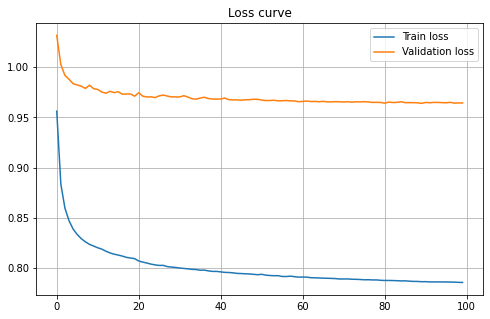

In [ ]:
#plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(history.epoch,history.history['loss'], label='Train loss')
plt.plot(history.epoch,history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss curve')
plt.grid(True)
plt.show()

Predicitons

59/59 [==============================] - 0s 5ms/step


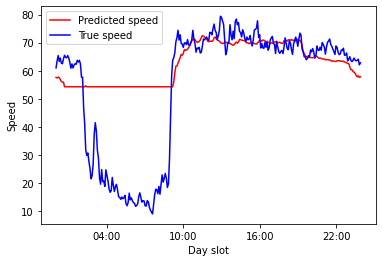

In [ ]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
true_values = scaler.inverse_transform(Y_test)

day = np.arange(day_size).tolist()

sensor_n = 1

l1, = plt.plot(day, predictions[:day_size, sensor_n], color='red')
l2, = plt.plot(day, true_values[:day_size, sensor_n], color='blue')

plt.legend((l1, l2), ['Predicted speed', 'True speed'])

plt.xlabel('Day slot')
plt.ylabel('Speed')
plt.xticks(np.arange(min(day) + 4*12, max(day) + 2, 6*12), labels=('04:00', '10:00', '16:00', '22:00'))

plt.show()

### Regression for daily predictions

Train the first 20 hours of each day and try to predict the last 4 hours of each day

In [ ]:
#remove date values if metr-la modified
#dataset = dataset[:,1:]

scores = []
mse_errors = []
mae_errors = []
mape_errors = []

for i in range(0, dataset.shape[0], 288):
  print(f'DAY [{i//288}] TRAINING\n')
  #take data from a single day
  day_data = dataset[i:i+288,:]

  #set train and test sizes
  train_rate = 0.8
  train_size = int(day_data.shape[0] * 0.8)

  train_set, test_set = day_data[:train_size, :], day_data[train_size:, :]

  day_scaler = StandardScaler()
  train_set = day_scaler.fit_transform(train_set)
  test_set = day_scaler.transform(test_set)

  #create X and Y sets
  X_train, Y_train = transform_data(train_set, M, H)
  X_test, Y_test = transform_data(test_set, M, H)

  #model
  model = keras.models.Sequential([
    tf.keras.Input(X_train.shape[1]),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(Y_train.shape[1], activation='relu')
  ])

  #model metrics
  model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy',keras.losses.MeanSquaredError(), keras.losses.MeanAbsoluteError(), keras.losses.MeanAbsolutePercentageError()])

  #train model
  history = model.fit(X_train, Y_train, epochs=100)

  #evaluate
  results = model.evaluate(X_test, Y_test)

  #evaluate
  scores.append(results[0])
  mse_errors.append(results[2])
  mae_errors.append(results[3])
  mape_errors.append(results[4])

Plot infos

AVERAGE SCORE = 0.44468073174357414
MIN ERROR = 0.21725407242774963
AVERAGE MSE = 0.4544199427420443
AVERAGE MAE = 0.44547761705788697
AVERAGE MAPE = 1430.1288995742798


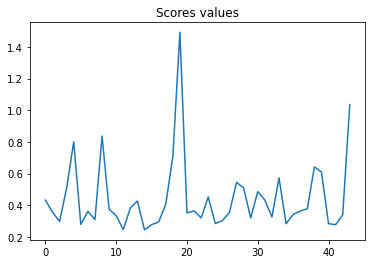

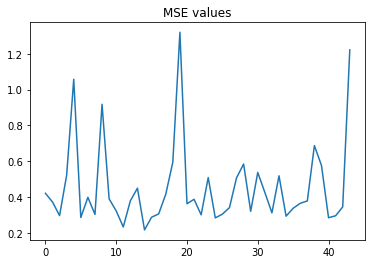

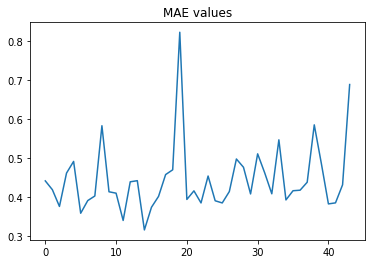

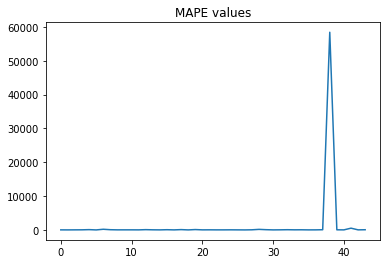

In [ ]:
print(f'AVERAGE SCORE = {sum(scores)/len(scores)}')
print(f'MIN ERROR = {min(mse_errors)}')

print(f'AVERAGE MSE = {sum(mse_errors)/len(mse_errors)}')
print(f'AVERAGE MAE = {sum(mae_errors)/len(mae_errors)}')
print(f'AVERAGE MAPE = {sum(mape_errors)/len(mape_errors)}')

plt.plot(range(len(scores)), scores)
plt.title('Scores values')
plt.show()

plt.plot(range(len(mse_errors)), mse_errors)
plt.title('MSE values')
plt.show()

plt.plot(range(len(mae_errors)), mae_errors)
plt.title('MAE values')
plt.show()

plt.plot(range(len(mape_errors)), mape_errors)
plt.title('MAPE values')
plt.show()

2/2 [==============================] - 0s 8ms/step


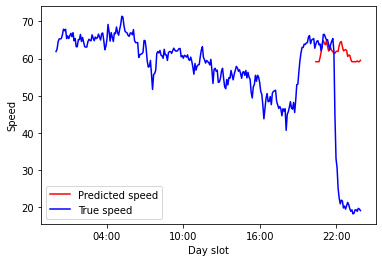

In [ ]:
#plot prediction of last sensor

day = np.arange(day_size).tolist()

sensor_num = dataset.shape[1]-1

predictions = model.predict(X_test)
predictions = day_scaler.inverse_transform(predictions)

l1, = plt.plot(day[245:], predictions[:,sensor_num], color='red')
l2, = plt.plot(day, day_data[:,sensor_num], color='blue')

plt.legend((l1, l2), ['Predicted speed', 'True speed'])

plt.xlabel('Day slot')
plt.ylabel('Speed')
plt.xticks(np.arange(min(day) + 4*12, max(day) + 2, 6*12), labels=('04:00', '10:00', '16:00', '22:00'))

plt.show()

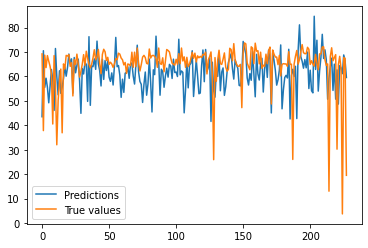

In [ ]:
#prediction on last measurement with values from all sensors
Y_test = day_scaler.inverse_transform(Y_test)
plt.plot(range(sensor_num+1), predictions[len(X_test)-1, :], label='Predictions')
plt.plot(range(sensor_num+1), Y_test[len(X_test)-1, :], label='True values')
plt.legend()
plt.show()

It does not seem to be able to learn.